#1. Ejemplo del método de clasificación Naive Bayes
#Crop mapping using fused optical-radar data set Data Set

Este gran conjunto de datos es un radar óptico bitemporal fusionado para la clasificación de tierras de cultivo. Las imágenes fueron recolectadas por satélites RapidEye (ópticos) y el sistema de radar de apertura sintética de vehículos aéreos no tripulados (UAVSAR) (Radar) sobre una región agrícola cerca de Winnipeg, Manitoba, Canadá en 2012.
Hay 2 * 49 funciones de radar y 2 * 38 funciones ópticas para dos fechas: 05 y 14 de julio de 2012.

Existen siete clases de tipos de cultivos para este conjunto de datos de la siguiente manera: 1-Maíz; 2-guisantes; 3- Canola; 4-soja; 5- Avena; 6- Trigo; y 7 de hoja ancha.

1.   Corn
2.   Peas;
3.Canola
4.Soybeans
5.Oats
6.Wheat
7.Broadleaf



Más: https://archive.ics.uci.edu/ml/datasets/Crop+mapping+using+fused+optical-radar+data+set





#2. Importación de librerías y montando google drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [22]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/7. Modelos de ensamble/7.2 Bagging'
dataset_path = os.path.join(path,'WinnipegDataset.txt')

# 3. Lectura y visualuzación del dataset

In [23]:
dataset = pd.read_csv(dataset_path)
dataset.dropna(axis=0, inplace=True)
dataset.drop_duplicates()
dataset.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,...,0.13580,0.650770,6711,6143,4570,5064,8212,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,...,0.30864,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,...,0.30864,0.613940,6215,5035,3033,3837,8588,0.47801,2.8315,1.6601,-0.70049,1.03530,0.71699,0.24814,0.260810,0.80946,0.38237,2.2382,0.38237,439570.0,0.117030,3321.3,128320.0,1.2651,49.444,0.24691,0.61111,0.77778,0.77778,1.3689,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,0.66378,2.2942,2.9580,0.32760,0.067825,0.60457,0.28135,0.47717,0.24148,-0.50405,-0.66998,-0.52543,-0.61169,-0.17507,-0.43576,0.127200,0.031091,0.006040,0.57769,0.67468,46.654,0.38976,0.18793,0.28492,0.13738,0.047480,0.14701,-11.056,-11.263,-19.529,...,0.16049,0.064018,6836,5745,4212,4534,7691,0.29228,1.8260,1.3640,-0.47512,0.65772,0.43840,0.15396,0.144830,0.60147,0.25824,1.6963,0.25824,296240.0,0.036817,1748.1,80640.0,1.0764,50.667,0.88889,0.61111,0.77778,0.77778,1.8892,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,0.83143,2.1756,3.0070,0.31701,0.069483,0.61351,0.28768,0.47476,0.23756,-0.50314,-0.68221,-0.50731,-0.59134,-0.17505,-0.45195,0.131550,0.031960,0.006439,0.57937,0.66460,46.828,0.38505,0.19432,0.27955,0.14108,0.048950,0.15156,-10.932,-11.109,-19.278,...,0.20988,0.657600,6682,5883,4434,4627,7072,0.22927,1.5949,1.3268,-0.40120,0.52776,0.34389,0.14045,0.091779,0.53551,0.20899,1.5284,0.20899,232610.0,0.021300,1365.4,69540.0,1.0435,51.222,0.39506,0.56667,1.66670,1.00000,1.7351,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000


In [24]:
dataset.shape

(325834, 175)

In [25]:
print ('Conteo de valores faltantes: \n')
print (dataset.isna().sum().sum())

Conteo de valores faltantes: 

0


Distribución de clases

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


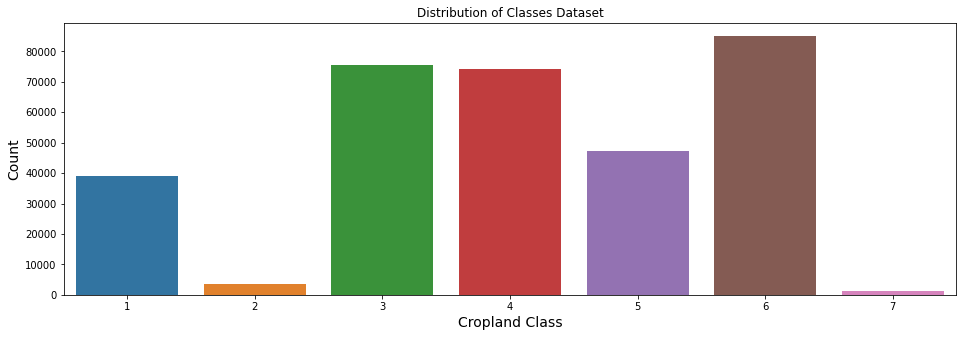

In [26]:
fig, ax =plt.subplots(figsize=(16,5))

sns.countplot('label', data=dataset)
plt.title('Distribution of Classes Dataset')
plt.xlabel('Cropland Class', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

In [27]:
class_distr = pd.Series(100 * dataset.label.value_counts(normalize=True)).sort_index()
print('Distribución de clases \n')
for i in range(0,7):
    print(f'Tipo de cultivo {class_distr.index[i]}: {class_distr.iloc[i]:.2f} %')

Distribución de clases 

Tipo de cultivo 1: 12.02 %
Tipo de cultivo 2: 1.10 %
Tipo de cultivo 3: 23.22 %
Tipo de cultivo 4: 22.73 %
Tipo de cultivo 5: 14.46 %
Tipo de cultivo 6: 26.11 %
Tipo de cultivo 7: 0.35 %


#3. Escalamiento y codificación de etiquetas

In [28]:
scaler = StandardScaler()
dataset.loc[:, dataset.columns != 'label'] = scaler.fit_transform(dataset.loc[:, dataset.columns != 'label'])

In [29]:
le = LabelEncoder()
dataset['label'] = le.fit_transform(dataset.label.values)
dataset.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,0,0.452194,0.646004,1.222832,0.901446,0.806041,0.853252,-1.433501,0.859635,-0.687087,0.350325,-0.516842,-0.367857,-1.484905,-0.273562,1.388123,0.566147,-0.440937,0.274757,1.386259,1.276394,0.910452,1.401508,0.727801,1.346347,0.623661,0.079049,-0.006912,-1.414522,-0.181418,0.467451,-1.003622,-0.214013,0.952770,1.260185,-0.762280,-0.562219,0.806041,0.919202,0.646004,...,-1.862375,0.230097,2.263054,1.225119,2.348681,0.551795,-0.938735,-1.941532,-1.732860,-2.023812,0.277421,-2.169973,-1.941505,-2.049624,-1.733907,-1.777757,-1.584425,-1.534615,-1.584425,-1.325525,-1.940098,-1.558375,-1.489568,-1.729452,0.787701,2.101347,-1.075359,0.713910,1.135903,1.395822,-1.011337,0.898027,2.461464,32.414869,-5.896123,25.696272,10.276661,2.652789,-2.025826,-0.028323
1,0,0.668218,0.910421,1.530373,1.202123,1.065370,1.106263,-1.581594,1.120757,-0.654580,0.662312,-0.709760,-0.434976,-1.644806,-0.174124,1.509309,0.828673,-0.579649,0.283347,1.466902,1.383150,1.026040,1.443885,0.775691,1.467752,1.059798,0.302761,0.183979,-1.661418,-0.264540,0.575317,-1.222002,-0.213899,1.084094,1.550623,-0.822435,-0.609727,1.065370,1.197063,0.910421,...,-1.259469,-0.860032,0.484329,-0.592452,0.126801,-1.171366,-0.937851,-0.730705,-0.933274,-0.924989,0.264431,-0.129431,-0.730732,-0.825710,-0.721798,-0.474250,-0.018167,-0.151415,-0.018167,-0.629368,-1.692310,-1.479315,-1.348097,-1.544421,1.051008,-0.067522,-1.747478,0.190167,1.135903,0.258723,-0.408790,-1.847469,-0.046765,0.101992,-0.814262,0.425134,0.767675,0.927648,-0.943871,-1.817572
2,0,0.774089,1.017223,1.629827,1.345995,1.149095,1.191416,-1.553474,1.171669,-0.600352,1.033551,-0.888007,-0.464799,-1.621587,-0.115194,1.475694,1.094543,-0.692520,0.242159,1.527163,1.457135,1.141397,1.458464,0.841501,1.574895,1.269379,0.362635,0.204457,-1.909799,-0.214324,0.657386,-1.329485,-0.311099,1.307726,1.658747,-0.924112,-0.722321,1.149095,1.313885,1.017223,...,-1.259469,0.156555,0.244181,-0.676551,-0.333982,-1.091032,-0.772553,-0.297810,-0.541713,-0.268917,0.236263,0.460403,-0.297798,-0.181951,-0.439596,-0.011432,0.127252,0.007387,0.127252,-0.469468,-0.957241,-0.920267,-0.834256,-0.954790,0.985082,-0.184759,-0.873741,-0.071690,0.456821,0.542952,-0.710064,-0.172181,0.039718,0.507598,-2.177504,1.911679,2.269153,1.811368,-1.665186,-1.194115
3,0,0.700464,1.109227,1.643904,1.412813,1.077913,1.200665,-1.734502,1.696652,-0.436719,1.392446,-1.204425,-0.634058,-1.828524,0.182583,1.595488,1.518073,-0.954952,0.325857,1.572832,1.509476,1.262722,1.468448,0.860644,1.654645,1.270664,0.298167,0.181821,-2.045496,-0.267203,0.863077,-1.453242,-0.307799,1.371976,1.834074,-0.950508,-0.743343,1.077913,1.345001,1.109227,...,-1.776251,-0.941525,2.771842,0.542028,1.723831,-0.157820,-1.169003,-1.878960,-1.699357,-1.913819,0.350667,-1.558907,-1.878960,-1.918181,-1.726142,-1.654961,-1.335540,-1.347805,-1.335540,-1.312990,-2.156242,-1.815062,-1.708005,-1.885864,1.226479,0.323268,-0.873741,-0.071690,0.456821,1.503238,-1.111802,0.245278,1.510077,1.318810,-0.814262,0.425134,0.767675,1.553319,-1.394670,-0.533756
4,0,0.701320,1.171138,1.708013,1.478013,1.116796,1.221070,-1.857209,1.902376,-0.416147,1.673608,-1.283512,-0.602220,-1.955272,0.263599,1.691195,1.669282,-0.984328,0.239516,1.574245,1.489810,1.297601,1.498910,0.860773,1.629158,1.350496,0.341562,0.255598,-2.020554,-0.363069,0.893203,-1.515055,-0.235069,1.282822,1.957169,-0.911432,-0.689303,1.116796,1.387035,1.171138,...,-1.603967,0.243735,2.145015,0.778879,2.111308,-0.033303,-1.442585,-2.415374,-1.965425,-2.120473,0.388191,-2.253937,-2.415359,-2.167241,-2.314628,-2.176174,-1.915919,-1.767691,-1.915919,-1.687463,-2.388185,-2.032732,-1.911416,-2.048198,1.

#4.  Selección de características (elegir uno)

In [30]:
#Feature selection
fs = SelectKBest(score_func=f_classif, k=15) #default 10 features
np_X = dataset.iloc[:, 1:].to_numpy()
np_Y = dataset.iloc[:, 0].to_numpy()
X_selec = fs.fit_transform(np_X, np_Y)
attr_names = dataset.columns.values.tolist()
# Lista de bools que indican si es un atributo seleccionado o no
mask = fs.get_support()
# Lista de los K mejores atributos
new_features = [] 
for bool, feature in zip(mask, attr_names):
    if bool:
        new_features.append(feature)
dataset_FS = pd.DataFrame(X_selec, columns=new_features)
dataset_FS['label'] = dataset['label']

dataset_FS.head()

,label,f4,f36,f39,f40,f49,f53,f85,f88,f91,f94,f99,f101,f137,f139
0,0,0.806041,0.806041,0.615132,0.677764,1.252324,1.604873,1.604873,1.467532,1.349743,1.309607,0.159859,0.959268,1.225119,0.551795
1,0,1.065370,1.065370,0.855587,0.910378,1.533960,1.929825,1.929825,1.873710,1.920462,1.856548,-0.358333,-0.621115,-0.592452,-1.171366
2,0,1.149095,1.149095,0.976462,1.054592,1.679402,2.084608,2.084608,2.183120,2.404650,2.311258,-0.278612,-0.519155,-0.676551,-1.091032
3,0,1.077913,1.077913,1.015890,1.114584,1.715833,2.176247,2.176247,2.393062,2.762553,2.668192,0.717912,-0.187784,0.542028,-0.157820
4,0,1.116796,1.116796,1.036622,1.178753,1.808030,2.273271,2.273271,2.567702,3.063810,2.969733,0.518607,0.092606,0.778879,-0.033303


In [31]:
#Componentes principales
pca = PCA(0.80)
pc = pca.fit_transform(dataset.iloc[:,1:])
dataset_pca = pd.DataFrame(data = pc, columns=range(pc.shape[1]))
dataset_pca = pd.concat([dataset.iloc[:,0], dataset_pca],  axis = 1)

print('Número de componentes principales: %s'%len(pca.explained_variance_ratio_))
print('Varianza acumulada con %s componentes: %s'%(len(pca.explained_variance_ratio_),np.sum(pca.explained_variance_ratio_)))

dataset_pca.head()

Número de componentes principales: 12
Varianza acumulada con 12 componentes: 0.8045079506717222


,label,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0.903034,9.932313,-4.596294,20.639667,9.528488,27.018174,11.576863,15.888702,14.331178,14.001722,7.620016,5.891011
1,0,2.543904,4.955726,4.587263,7.278983,-1.727353,4.049668,-1.561079,-1.740462,1.443943,-0.332719,-0.883552,3.109931
2,0,3.766261,5.410671,4.682735,7.171676,-1.852819,5.480929,-0.791732,-0.641056,2.966688,-0.517316,-1.402675,3.994595
3,0,2.489494,8.868151,1.146446,12.598159,-2.306405,4.197886,-0.873311,-2.339489,1.933906,1.502941,-0.360492,4.513411
4,0,2.178039,9.037277,1.445547,14.076990,-2.147240,3.972911,-1.053679,-0.499561,3.280958,-0.428910,-0.651444,4.068721


#5. Dividiendo el conjunto en entrenamiento y prueba

In [32]:
X = np.array(dataset_FS.iloc[:,1:])
y = np.array(dataset_FS['label'])

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 0)

print(f'Dimension de los datos de entrenamiento {X_train.shape}')
print(f'Dimension de los datos de prueba {X_test.shape}')

Dimension de los datos de entrenamiento (162917, 14)
Dimension de los datos de prueba (162917, 14)


#6. Entrenando y prediciendo con CART

In [34]:
dectree = DecisionTreeClassifier(max_depth= 50) 
dectree = dectree.fit(X_train,y_train)

In [35]:
y_pred = dectree.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.9618149118876483


In [36]:
#Funciones para MC y métricas
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    #plt.grid(b=None)
    plt.show()
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

In [37]:
clases = dataset['label'].unique().tolist()
n_clases = len(clases)
pesos = dataset['label'].value_counts().sort_index().tolist()/ np.sum(dataset['label'].value_counts().tolist())

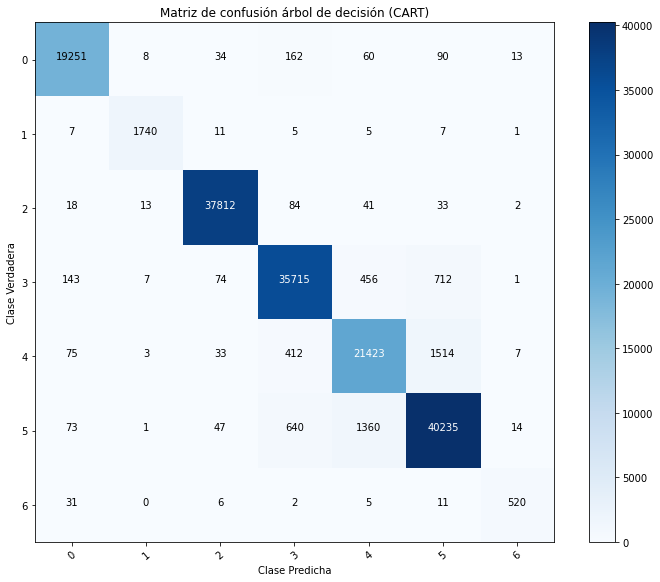

In [38]:
predictions = np.float32(y_pred)
true_labels = np.float32(y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión árbol de decisión (CART)'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

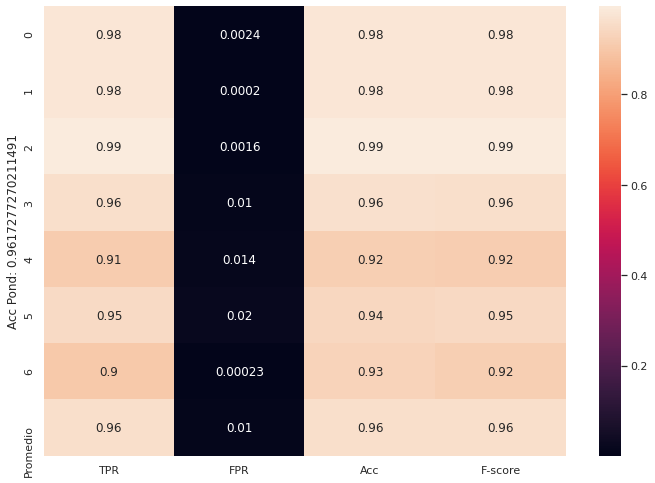

In [39]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

#7. Entrenando y prediciendo con Random Forest

In [40]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, n_jobs=4)

random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [41]:
y_pred_rf = random_forest_classifier.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred_rf)
print("Test Acc: %s"%score)

Test Acc: 0.9812849487775984


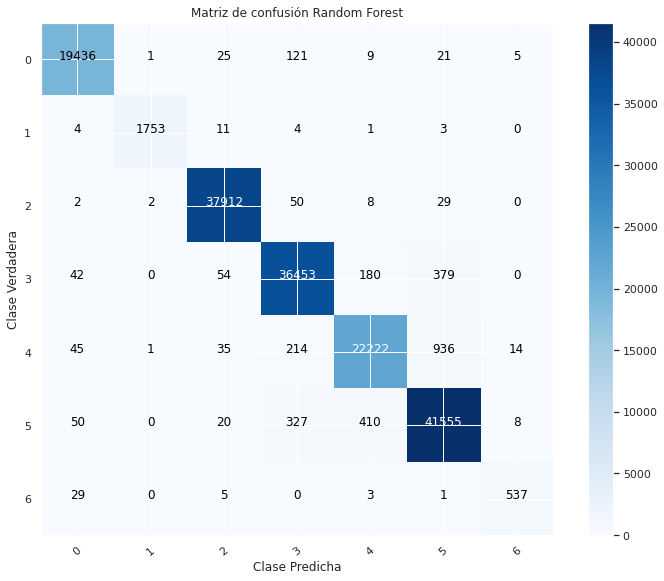

In [42]:
predictions = np.float32(y_pred_rf)
true_labels = np.float32(y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión Random Forest'
plot_confusion_matrix(cnf_matrix, clases, tit, normalize=False)

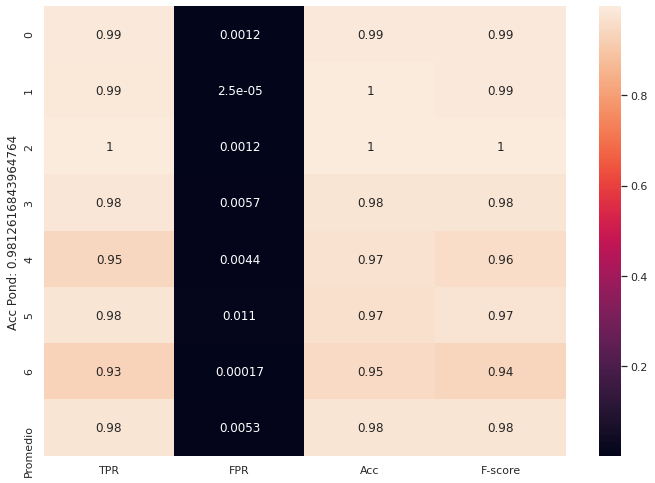

In [43]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)